In [2]:
import numpy as np
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt

In [10]:
# Define constants
n_control_points = 8  # Number of control points for position and yaw
trajectory_length = 5.0  # From (0, 0) to (5, 0)
obstacle_position = np.array([2.5, 0.5])  # Obstacle position
n_samples = 5  # Number of points to sample along the trajectory

# Define the start and end positions for the trajectory
start_position = np.array([0, 0])  # Initial position
end_position = np.array([5, 0])    # Final position

# Dynamically generate the initial straight-line trajectory control points
initial_pos_control_points = np.linspace(start_position, end_position, n_control_points)
initial_yaw_control_points = np.zeros(n_control_points)  # Yaw is initialized to 0 for all points

# Desired first and last states for position and yaw (hard constraints)
desired_first_position = np.array([0.0, 0.0])  # Initial position
desired_last_position = np.array([5.0, 0.0])   # Final position
desired_first_yaw = 0.0  # Initial yaw
desired_last_yaw = 0.0   # Final yaw

# Generate sampled points along the trajectory
sampled_points = np.linspace(0, trajectory_length, n_samples)
initial_trajectory = np.vstack([sampled_points, np.zeros(n_samples)]).T

# Objective function to minimize
def objective(x):
    pos_control_points = x[:n_control_points * 2].reshape(n_control_points, 2)
    yaw_control_points = x[n_control_points * 2:]

    # 1. Position trajectory cost (minimizing deviation from initial control points)
    J_pos = np.sum((pos_control_points - initial_pos_control_points)**2)

    # 2. Yaw tracking cost (yaw should point towards the obstacle)
    J_tracking = 0
    for i in range(n_control_points):
        tracking_vector = obstacle_position - pos_control_points[i]
        desired_yaw = np.arctan2(tracking_vector[1], tracking_vector[0])  # True yaw
        t = i / (n_control_points - 1)
        yaw_at_point = (1 - t) * yaw_control_points[0] + t * yaw_control_points[-1]  # Linear interpolation
        J_tracking += (desired_yaw - yaw_at_point)**2

    # 3. Yaw rate smoothness cost (minimizing changes in yaw)
    J_yaw_dot = np.sum(np.diff(yaw_control_points)**2)

    # 4. Pos rate smoothness cost (minimizing changes in pos)
    J_pos_dot = np.sum(np.diff(pos_control_points, axis=0)**2)

    # Total objective
    return 0.5 * J_pos + 10 * J_tracking + 20.0 * J_yaw_dot + 100.0 * J_pos_dot

# Hard constraints for the first and last state
def constraint_first_position(x):
    pos_control_points = x[:n_control_points * 2].reshape(n_control_points, 2)
    return pos_control_points[0] - desired_first_position

def constraint_last_position(x):
    pos_control_points = x[:n_control_points * 2].reshape(n_control_points, 2)
    return pos_control_points[-1] - desired_last_position

def constraint_first_yaw(x):
    yaw_control_points = x[n_control_points * 2:]
    return yaw_control_points[0] - desired_first_yaw

def constraint_last_yaw(x):
    yaw_control_points = x[n_control_points * 2:]
    return yaw_control_points[-1] - desired_last_yaw

# Define the constraints
constraints = [
    {'type': 'eq', 'fun': constraint_first_position},
    {'type': 'eq', 'fun': constraint_last_position},
    {'type': 'eq', 'fun': constraint_first_yaw},
    # {'type': 'eq', 'fun': constraint_last_yaw}
]

# Initial guess: concatenate position and yaw control points
x0 = np.hstack((initial_pos_control_points.flatten(), initial_yaw_control_points))

# measure conmputational time
start = time.time()

# Minimize using SciPy's minimize function (SLSQP)
res = minimize(objective, x0, method='SLSQP', constraints=constraints)

print("Time taken: ", time.time() - start)

# Extract optimized control points
optimized_pos_control_points = res.x[:n_control_points * 2].reshape(n_control_points, 2)
optimized_yaw_control_points = res.x[n_control_points * 2:]


Time taken:  0.0721137523651123


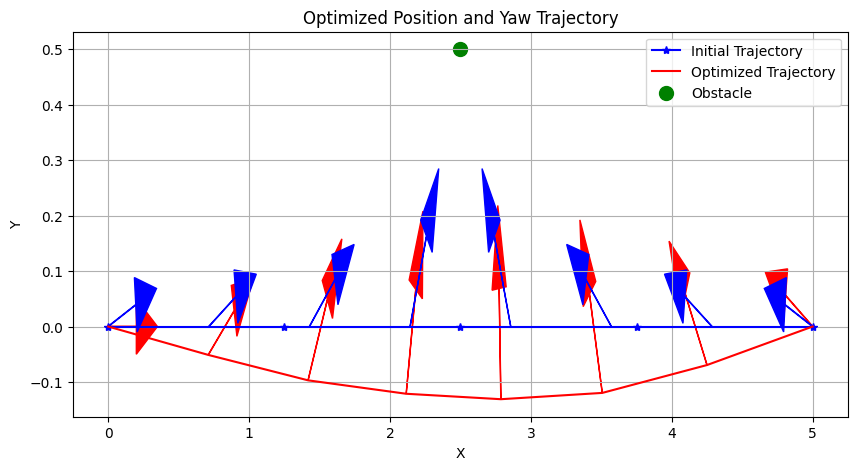

In [11]:
# Plot the results
plt.figure(figsize=(10, 5))

# Plot the initial trajectory
plt.plot(initial_trajectory[:, 0], initial_trajectory[:, 1], 'b-*', label='Initial Trajectory')

# Plot the optimized trajectory
plt.plot(optimized_pos_control_points[:, 0], optimized_pos_control_points[:, 1], 'r-', label='Optimized Trajectory')

# Plot the obstacle
plt.scatter(*obstacle_position, color='green', s=100, label='Obstacle')

# Add yaw direction indicators
for i in range(n_control_points):
    pos = optimized_pos_control_points[i, :]
    yaw = optimized_yaw_control_points[i]
    yaw_vector = np.array([np.cos(yaw), np.sin(yaw)])
    plt.arrow(pos[0], pos[1], 0.2 * yaw_vector[0], 0.2 * yaw_vector[1], color='red', head_width=0.1)

# Add the original desired tracking direction
for i in range(n_control_points):
    tracking_vector = obstacle_position - initial_pos_control_points[i]
    desired_yaw = np.arctan2(tracking_vector[1], tracking_vector[0])
    desired_yaw_vector = np.array([np.cos(desired_yaw), np.sin(desired_yaw)])
    plt.arrow(initial_pos_control_points[i, 0], initial_pos_control_points[i, 1], 0.2 * desired_yaw_vector[0], 0.2 * desired_yaw_vector[1], color='blue', head_width=0.1)

plt.legend()
plt.title("Optimized Position and Yaw Trajectory")
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()